In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import pandas as pd

In [75]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [77]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#### Explore Database

In [78]:
# -- using inspector tool
from sqlalchemy import inspect

In [79]:
# create the inspector and connect it to the engine
inspector=inspect(engine)

In [80]:
# collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

* => table 'measurement'

In [81]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
#columns
for column in columns:
    print(column["name"], column["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [82]:
# Use `engine.execute` to select and display the first 5 rows
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()
        
    # => NULL values exist in 'prcp'

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

* => table 'station'

In [83]:
# Using the inspector to print the column names and data types
columns = inspector.get_columns('station')
#columns
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [84]:
# Use `engine.execute` to select and display rows
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

#### Reflect database
* Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called **Station** and **Measurement**.

In [85]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [86]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [87]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [88]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis
* Design a query to retrieve the last 12 months of precipitation data and plot the results

In [89]:
# Calculate the date 1 year ago from the last data point in the database

# Last date in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
   

# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(Measurement.prcp, Measurement.date) \
            .filter(Measurement.date >= year_ago).all()


# Save the query results as a Pandas DataFrame
prec_df = pd.DataFrame(prec_data, columns=['precipitation','date'])


# set the index to the date column and sort the dataframe by date
prec_df = prec_df.set_index('date').sort_index()


prec_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


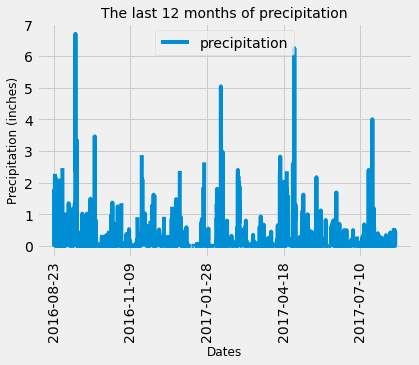

In [90]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(rot=90)

plt.title("The last 12 months of precipitation", fontsize=14)
plt.xlabel("Dates",fontsize=12)
plt.ylabel("Precipitation (inches)",fontsize=12)

#plt.tight_layout()
plt.show()


In [91]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [92]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurement.station).distinct().count() 

9

In [93]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                    .group_by(Measurement.station) \
                    .order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [94]:
# the most active station
most_active = active_stations[0][0]
most_active

'USC00519281'

In [95]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.max(Measurement.tobs), \
              func.min(Measurement.tobs), \
              func.avg(Measurement.tobs)) \
            .filter(Measurement.station == most_active).one()


(85.0, 54.0, 71.66378066378067)

* Design a query to retrieve the last 12 months of temperature observation data (TOBS) and plot the results as a histogram

In [96]:
# Choose the station with the highest number of temperature observations.

most_active_tobs = session.query(Measurement.station, func.count(Measurement.tobs)) \
                       .group_by(Measurement.station) \
                       .order_by(func.count(Measurement.tobs).desc()).first()[0]

# Query the last 12 months of temperature observation data for this station 

tobs_data = session.query(Measurement.date, Measurement.tobs) \
                    .filter((Measurement.station == most_active_tobs)\
                            ,(Measurement.date >= year_ago)).all()
            
# save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data)
tobs_df.head()


,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


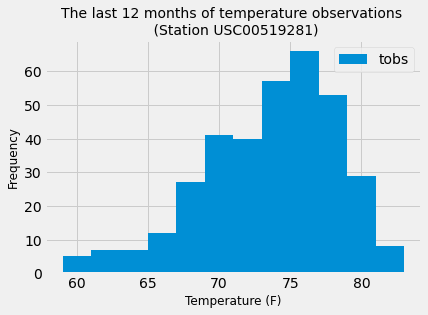

In [97]:
# plot the results as a histogram
tobs_df.plot.hist(bins=12)

plt.title(f"The last 12 months of temperature observations \n (Station {most_active_tobs})",fontsize=14)
plt.xlabel("Temperature (F)", fontsize=12)
plt.ylabel("Frequency",fontsize=12)

#plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [98]:
# Identify the average temperature at all stations across all available years
# --> in June
june_temp = session.query(func.avg(Measurement.tobs)) \
                .filter(func.strftime("%m", Measurement.date) == "06").scalar()

# --> in December
december_temp = session.query(func.avg(Measurement.tobs)) \
                .filter(func.strftime("%m", Measurement.date) == "12").scalar()

print(f"The average temperatures in June and December are {round(june_temp,2)}F and {round(december_temp,2)}F accordingly" )

The average temperatures in June and December are 74.94F and 71.04F accordingly


In [99]:
# -- t-test

### Temperature Analysis II

In [100]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [101]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#----------------------------------------------------------------
# for my "back-to-the-future" trip dates 12/28/17-1/3/2018:
year_ago_start = dt.date(2017,12,28) - dt.timedelta(days=365)
year_ago_end = dt.date(2018,1,3) - dt.timedelta(days=365) 

trip_temp_result = calc_temps(year_ago_start,year_ago_end)
trip_temp_result


[(62.0, 69.81395348837209, 77.0)]

In [102]:
trip_tavg = trip_temp_result[0][1]
trip_tmax = trip_temp_result[0][2]
trip_tmin = trip_temp_result[0][0]

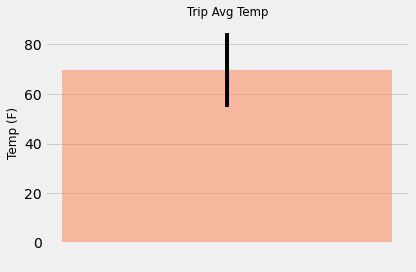

In [103]:
# Plot the results from your previous query as a bar chart. 
#--------------------------------------------------------------
# Use the average temperature for the y value
y = trip_tavg

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = trip_tmax - trip_tmin

plt.bar(1, y, yerr=yerr, color='coral', alpha=0.5)

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp", fontsize="small")
plt.xticks(np.arange(1))
plt.xlabel(" ")
plt.ylabel("Temp (F)", fontsize=12)

plt.tight_layout()
plt.show()


In [104]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(func.sum(Measurement.prcp), Station.station,Station.name, \
              Station.latitude, Station.longitude, Station.elevation) \
        .filter(Measurement.date >= year_ago_start \
                ,Measurement.date <= year_ago_end) \
        .filter(Measurement.prcp != None) \
        .filter(Measurement.station == Station.station) \
        .group_by(Measurement.station) \
        .order_by(func.sum(Measurement.prcp).desc()).all()


[(4.470000000000001,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (1.3900000000000001,
  'USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 (1.2300000000000002,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (1.19,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.19, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.18,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5)]

In [105]:
# # Create a query that will calculate the daily normals 
# # (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

# def daily_normals(date):
#     """Daily Normals.
    
#     Args:
#         date (str): A date string in the format '%m-%d'
        
#     Returns:
#         A list of tuples containing the daily normals, tmin, tavg, and tmax
    
#     """
    
#     sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
#     return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
# daily_normals("01-01")

In [106]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [107]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [108]:
# Plot the daily normals as an area plot with `stacked=False`
